In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('ml-1m/users.dat', sep='::', header=None, names=unames, engine='python')

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', header=None, names=rnames, engine='python')

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('ml-1m/movies.dat', sep='::', header=None, names=mnames, engine='python')

In [57]:
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [58]:
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [59]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [60]:
#merging all the three tables
data = pd.merge(pd.merge(ratings, users), movies)

In [61]:
data[:5]

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [62]:
#Question1
#An aggregate of the movie ratings for each particular genre
#make a copy of the original.
data_copy = data.copy()
#add all the genres in a list.
genres_list = data_copy.set_index(data_copy.columns.drop('genres',1).tolist())
#split the genres and then listing them along with the mean ratings.
data_with_split_genre = genres_list.genres.str.split('|', expand=True).reset_index().rename(columns={0:'genres'}).loc[:, data_copy.columns]
mean_by_genre = data_with_split_genre.groupby('genres').agg({'rating': [np.mean]})
mean_by_genre

,rating
,mean
genres,
Action,3.491185
Adventure,3.435503
Animation,3.725958
Children's,3.313527
Comedy,3.542505
Crime,3.876721
Documentary,3.935896
Drama,3.772144


In [63]:
#Question2
#The top 5 highest ranked genre by women.

#Create a dataframe of genre and gender.
df_with_genre_gender = data_with_split_genre.pivot_table('rating', index=['genres','gender'], aggfunc='mean')

#query the data and fetch all the rows with gender "F".
ratings_by_women = df_with_genre_gender.query('gender == ["F"]')
#sort the rows in decending order wrt rating.
top_ratings_by_women = ratings_by_women.sort_values(by='rating', ascending=False)
top_ratings_by_women[:5]

,,rating
genres,gender,
Film-Noir,F,4.151354
Musical,F,4.067159
Documentary,F,3.944183
Mystery,F,3.855780
War,F,3.841584


In [64]:
#Question3
#The top 5 highest ranked genre by men.

#using the same dataframe from above, query the data and fetch all the rows with gender "M".
ratings_by_men = df_with_genre_gender.query('gender == ["M"]')
#sort the rows in decending order wrt rating.
top_ratings_by_men = ratings_by_men.sort_values(by='rating', ascending=False)
top_ratings_by_men[:5]

,,rating
genres,gender,
Film-Noir,M,4.172234
Documentary,M,3.933138
War,M,3.894382
Crime,M,3.889421
Western,M,3.878497


In [65]:
#Question4
#Pick a movie of your choice and provide a breakdown of the movie’s ratings by 3 age ranges (a) under 18 (b) 19 to 45 (c) Above 45.

#fecthing all the unique age in the data
available_ages = data.age.unique()
available_ages.sort()
available_ages

array([ 1, 18, 25, 35, 45, 50, 56], dtype=int64)

In [66]:
#creating three age ranges according to the requirement.
age_range = { 1: '1-18', 18: '1-18', 
    25: '19-45', 35: '19-45', 45: '19-45', 
    50: 'Above 45',56: 'Above 45'
}
data['age_range'] = [age_range[n] for n in data['age']]
# selecting Shawshank Redemption, The (1994), fetching the deatils of the movie
the_movie = data[data.title == "Shawshank Redemption, The (1994)"]
ratings_by_age_range = the_movie.pivot_table('rating', index='age_range', columns='title')
ratings_by_age_range

title,"Shawshank Redemption, The (1994)"
age_range,
1-18,4.662745
19-45,4.546758
Above 45,4.380952


In [67]:
#Question5
#A function that given a user id and movie id , returns a list of user ids for other users that rated the movie identified by the provided movie id with the same score.

def otherUsersWithSameRating(uid, mid):
    ratings_of_uid = data[data.user_id==uid]
    movies_rated_by_uid = ratings_of_uid[ratings_of_uid.movie_id == mid]
    rating = movies_rated_by_uid.loc[movies_rated_by_uid.index[0], 'rating']
    data_matched = data[data.movie_id == mid]
    users_matched = data_matched.user_id[data_matched.rating == rating]
    users_matched_list = users_matched.tolist()
    #remove the given user id
    users_matched_list.remove(uid)
    return users_matched_list

In [68]:
otherUsersWithSameRating(2,318)[:15]

[9, 11, 17, 22, 29, 33, 34, 39, 51, 53, 55, 58, 67, 76, 82]

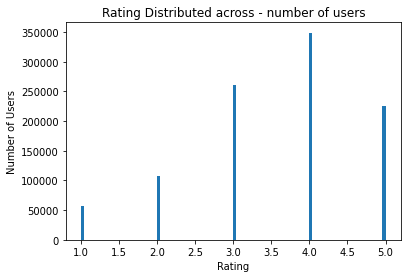

In [69]:
#Question6
#Some other statistic, figure, aggregate, or plot that you created using this dataset,
#along with a short description of what interesting observations you derived from it.

# Rating distribution - more number of people are tend to give 4 rating.
data.rating.plot.hist(bins=100)
plt.title("Rating Distributed across - number of users")
plt.ylabel('Number of Users')
plt.xlabel('Rating');


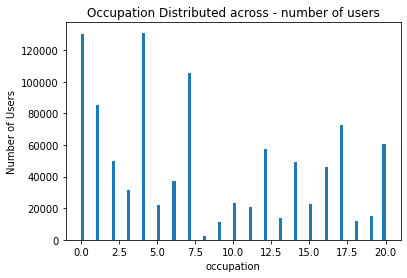

In [70]:
#Occupation distribution - people are distributed across different occupations.
data.occupation.plot.hist(bins=100)
plt.title("Occupation Distributed across - number of users")
plt.ylabel('Number of Users')
plt.xlabel('occupation');

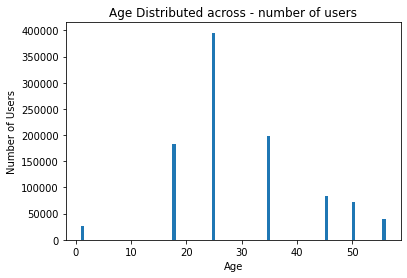

In [71]:
#Age distribution - people between the age 20-30 rated the movies more.
data.age.plot.hist(bins=100)
plt.title("Age Distributed across - number of users")
plt.ylabel('Number of Users')
plt.xlabel('Age');

In [72]:
# The following dataframes are created to compare "Childres's" genre and "Drama" genre

# listing all the data with genre "Children's"
data_children_genre = data_with_split_genre[data_with_split_genre.genres == "Children's"]
data_children_genre


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
28883,1,1097,4,978301953,F,1,10,48067,E.T. the Extra-Terrestrial (1982),Children's
28884,4,1097,4,978293964,M,45,7,02460,E.T. the Extra-Terrestrial (1982),Children's
28885,10,1097,5,979168108,F,35,1,95370,E.T. the Extra-Terrestrial (1982),Children's
28886,13,1097,5,978201368,M,45,1,93304,E.T. the Extra-Terrestrial (1982),Children's
28887,17,1097,3,978160616,M,50,1,95350,E.T. the Extra-Terrestrial (1982),Children's
...,...,...,...,...,...,...,...,...,...,...
998420,4079,1426,5,990617766,M,35,17,26505,Zeus and Roxanne (1997),Children's
998421,4150,1426,2,965344367,M,25,0,29672,Zeus and Roxanne (1997),Children's
998422,5558,1426,1,959391682,M,1,10,02446,Zeus and Roxanne (1997),Children's
998423,5698,1426,2,958595285,M,35,14,55418,Zeus and Roxanne (1997),Children's


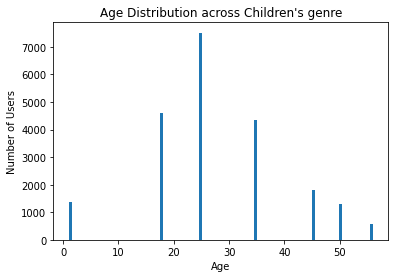

In [73]:
data_children_genre.age.plot.hist(bins=100)
plt.title("Age Distribution across Children's genre")
plt.ylabel('Number of Users')
plt.xlabel('Age');

In [74]:
# listing all the data with genre drama
data_drama_genre = data_with_split_genre[data_with_split_genre.genres == "Drama"]
data_drama_genre

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000196,5328,2438,4,960838075,F,25,4,91740,Outside Ozona (1998),Drama
1000198,5334,127,1,960795494,F,56,13,46140,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama
1000199,5334,3382,5,960796159,F,56,13,46140,Song of Freedom (1936),Drama
1000205,5675,2703,3,976029116,M,35,14,30030,Broken Vessels (1998),Drama


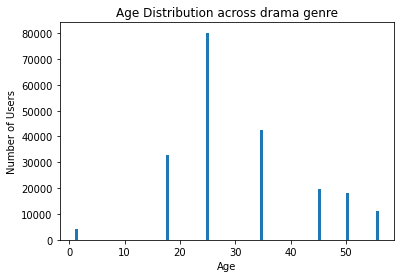

In [75]:
data_drama_genre.age.plot.hist(bins=100)
plt.title("Age Distribution across drama genre")
plt.ylabel('Number of Users')
plt.xlabel('Age');

In [76]:
#Inference after comparing dataframes of "Childres's" genre and "Drama" genre :
#--> 21491 number of rows of data available of "Children's" genre and the count is very less compared to 208627 rows of data of the "Drama" genre.
#--> The number of movies are more with drama genre rather than children's genre.
#--> By the graph, we can infer people of the age between 10-20 are interested in children's genre movies than drama's.
